In [1]:
import numpy as np
import scipy as sci
import math as m
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from corgi.functional import memoize

%matplotlib inline

In [1]:
# Just trying to debug Keith Araneo's work where he's porting his code from R to python.

# The idea is to estimate the MLE of the parameters given data. This is done with the Newton-Raphson method.

In [463]:
# draw random sample of 1000 observations from a 1-parameter Weibull distribution #
n=1000
shape= 2.0
scale = 20
weib1 = np.random.weibull(shape,n)

# include scale parameter for a 2-parameter weibull which we will use as our
#survival dataset in our case we'll just say the data points represent the
#amount of time in years after a treatment that a patient dies or experiences a relapse
#years = [scale*y for y in weib1]
years = weib1*scale

print(min(years), max(years))

0.500804576696 50.1734687448


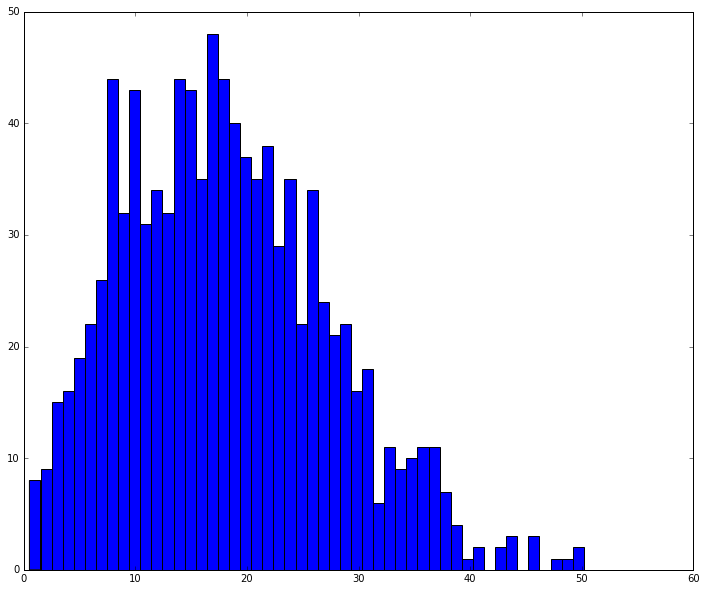

In [464]:
plt.hist(years,50)
plt.show()

In [465]:
# cool looks like we have some fine weibull distributed data

# with the 2-parameter Weibull, it's impossible to explicitly solve for unknown
# shape and scale parameters as a function of the data via maximum likelihood but with
# Newton-Raphson we can solve for an estimate of beta_hat by defining an arbitrary
# set of parameters to find one that is a close estimate of the true parameters we defined

# now for the  newton function #
# recall the newton method is a numerical way to find the roots of a
# function, f(x). We define a set of values x_1,x_2,x_3,...,x_n, where

#                 x_n = x_n-1 - (f(x_n-1)/f'(x_n-1)) 

# we want to find the root for and f'(x) is the first derivative w.r.t. x

In [466]:
@memoize
def g_beta(beta):
    # define some of the values in the MLE equations we're working with#
    A_numerator_sum = [(xi**beta) * (m.log(xi)) for xi in years]
    A_numerator = sum(A_numerator_sum)
    A_denominator_sum = [xi**beta for xi in years]
    A_denominator = sum(A_denominator_sum)
    A = A_numerator / A_denominator
    B = 1 / beta
    C_numerator_sum = [m.log(xi) for xi in years]
    C_numerator = sum(C_numerator_sum)
    C = C_numerator / n
    return A - B - C

@memoize
def g_beta_prime(beta):
    # More values that we need from the derivative w.r.t. beta
    # of the log likelihood function of weibull distribution
    D_first_sum = [xi**beta for xi in years]
    D_first = sum(D_first_sum)
    D_second_sum = [(xi**beta)* m.log(xi)*m.log(xi) for xi in years]
    D_second = sum(D_second_sum)
    D = D_first * D_second
    E_first_sum = [xi**beta * m.log(xi) for xi in years]
    E_first = sum(E_first_sum)
    E_second_sum = [xi**beta * m.log(beta) for xi in years]
    #E_second = sum(E_second_sum)
    #E = E_first * E_second
    E = E_first**2
    F_sum = [xi**beta for xi in years]
    F = sum(F_sum)
    G = (1/(beta**2))
    return ((D-E)/(F**2))+ G

In [475]:
x0, xs, deltas = newton(g_beta, g_beta_prime, 3.0)

  0%|          | 0/10000 [00:00<?, ?it/s]

- initial delta 1.21878786706
--- -break at -0.250054661404
root is at:  1.78121213294


In [467]:
# See Bain and Englehardt "Introduction to Probability and Mathematical Statistics
# Second Edition page 301 for an example

In [468]:
def newton(f, df, x0, e=1e-5, limit=1e4): #x0 is the arbitrary starting guess.
    delta = f(x0) / df(x0)
    print('- initial delta', delta)
    
    i = 0
    deltas = []
    xs = []
    x = None
    
    for i in tqdm(range(int(limit))):
        xs.append(x0)
        deltas.append(delta)

        x0 -= delta            
        delta = f(x0) / df(x0)
            
        if delta <= e:
            print('--- -break at', delta)
            break
            
    print('root is at: ', x0)
    return x0, xs, deltas
    #return x0

In [469]:
def g(beta):
    return ((years**beta * np.log(years)).sum() / (years**beta).sum()) \
        - (1 / beta) \
        - (np.log(years).sum() / n)

def g_prime(beta):
    return (1/(beta**2)) \
        - ((((years**beta) * np.log(years)).sum()**2) / ((years**beta).sum()**2)) \
        + (((years**beta) * (np.log(years)**2)).sum()**2 / (years*beta).sum())

In [470]:
g(3)

0.27042677394324288

In [471]:
g_prime(3)

277908690168.60687

In [472]:
g(3) / g_prime(3)

9.7307778961203148e-13

In [473]:
# test the following code 
x0, xs, deltas = newton(g, g_prime, 3.0)
#x0 = newton(g_beta_vectorized, g_beta_prime_vectorized, 2.0, 0.01)

  0%|          | 0/10000 [00:00<?, ?it/s]

- initial delta 9.73077789612e-13
--- -break at 9.73077789617e-13
root is at:  3.0


In [445]:
xs

[3.0]

In [446]:
xs[0], xs[-1]

(3.0, 3.0)

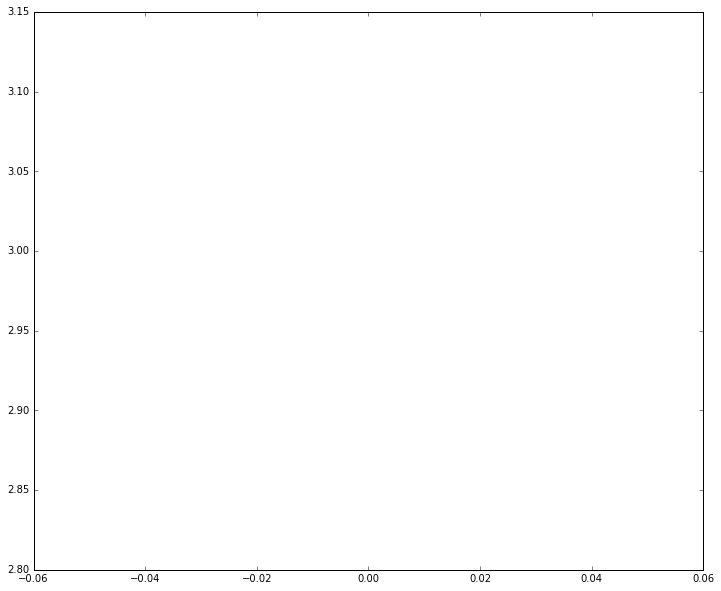

In [447]:
plt.plot(range(len(xs)), xs)

In [448]:
deltas[0], deltas[-1]

(9.0365018014726567e-14, 9.0365018014726567e-14)

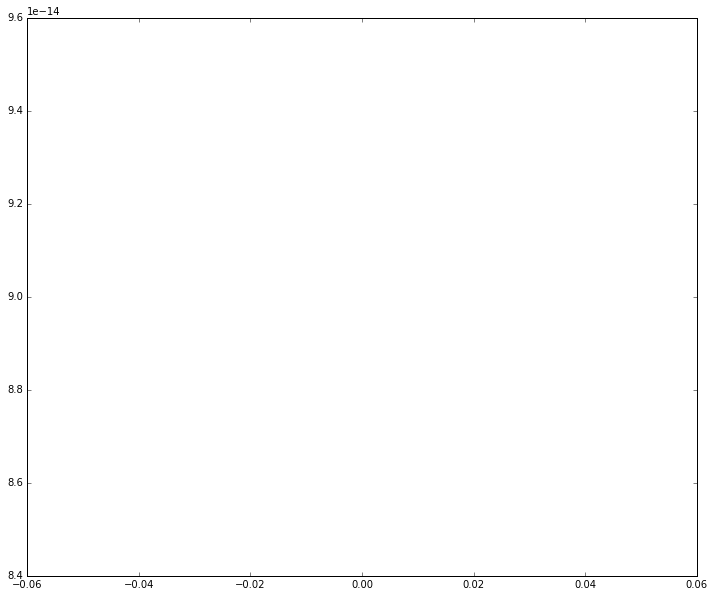

In [396]:
plt.plot(range(len(deltas)), deltas)

In [397]:
def theta(beta_hat):
    H_sum = [((xi**beta_hat)/n) for xi in years]
    H = sum(H_sum)
    print('For the beta-hat estimate of: ',beta_hat)
    print('the theta-hat estimate is: ',H**(1/beta_hat))

In [398]:
theta(2.311902505938026)

For the beta-hat estimate of:  2.311902505938026
the theta-hat estimate is:  20.1286886065
